In [15]:
import numpy as np
import scipy
import scipy.stats
from scipy.stats import norm
from matplotlib import pyplot as plt

## Sensor classes

In [29]:
class Sensor:
    def __init__(self):
        self._gen = self._genf()
    
    def _genf(self):
        raise NotImplementedError("Method '_genf' must be implemented")
    
    def reset(self):
        self._gen = self._genf()
        
    def next(self, num=1):
        if num == 1: return next(self._gen)
        return np.array([next(self._gen) for _ in range(num)])

class MCM(Sensor):
    def __init__(self, a_0, beta, M):
        self.a_0 = a_0
        self.beta = beta
        self.M = M
        super().__init__()
        
    def _genf(self):
        a_t_prev = 0
        a_t = self.a_0
        #yield a_t/self.M
        while True:
            a_t_prev = a_t
            a_t = (self.beta*a_t_prev)%self.M
            at = a_t/self.M
            yield at

class MM(Sensor):
    def __init__(self, K, D1, D2):
        self.K = K
        self.D1 = D1
        self.D2 = D2
        super().__init__()
        
    def _genf(self):
        D1.reset()
        D2.reset()
        V = np.array(D1.next(K))
        while True:
            s = int(np.floor(D2.next()*K))
            at = V[s]
            V[s] = D1.next()
            yield at
            
class Test:
    def __init__(self, sensor):
        self.sensor = sensor
    def evaluate(self, n, eps=0.05):
        self.sensor.reset()
        a = self.sensor.next(n)
        return self._test(a, eps)
    def _test(self, a, eps):
        raise NotImplementedError("Method 'evaluate' must be implemented")

class MomentsCoincidence(Test):
    def _test(self, a, eps):
        n = len(a)
        m = np.sum(a)/n
        s = np.sum((a-m)*(a-m))/(n-1)
        ksi1 = m - 1/2
        ksi2 = s - 1/12
        c1 = np.sqrt(n*12)
        c2 = (n-1)/n*(0.0056*n**(-1)+0.0028*n**(-2)-0.0083*n**(-3))**(-0.5)
        d = norm.ppf(1-eps/2)
        print(c1*np.abs(ksi1), c2*np.abs(ksi2))
        return c1*np.abs(ksi1) < d and c2*np.abs(ksi2) < d
    
class Covariation(Test):
    def __init__(self, sensor, t):
        super().__init__(sensor)
        self.t = t
    def _test(self, a, eps):
        n = len(a)
        m = np.sum(a)/n
        s = np.sum((a-m)*(a-m))/(n-1)

        R = lambda j: 1/12 if j == 0 else 0
        R_ = lambda j: np.sum(a[:n-j]*a[j:])/(n-j-1)-n/(n-1)*m*m
        c = lambda j: np.sqrt(2) if j == 0 else 1
        d = norm.ppf(1-eps/2)

        for j in range(self.t):
            left = np.abs(R(j)-R_(j))
            right = c(j)*d/(12*np.sqrt(n-1))
            if j < 20: 
                print(j, left, right, left >= right)
                
            if np.abs(R(j)-R_(j)) >= c(j)*d/(12*np.sqrt(n-1)):
                return False
        return True
    def get_corr(self, n):
        self.sensor.reset()
        a = self.sensor.next(n)
        return np.array([np.sum(a[:n-j]*a[j:])/(n-j-1) for j in range(self.t)])

## Параметры
(вариант 4)

In [3]:
n = 1000
a01 = 296454621
c1 = 48840859
a02 = 302711857
c2 = 37330745
K = 64
M = 2**31

## Основные задания

а) Осуществить моделирование $n=1000$ реализаций БСВ с помощью мультипликативного конгруэнтного метода (МКМ) с параметрами $a_0=a_{01}$, $\beta=max(c_1,M-c_1)$, $M=2^{31}$ и вывести 1000-ый элемент сгенерированной последовательности.

In [18]:
beta = max(c1, M-c1)
D1 = MCM(a01, beta, M)
print(D1.next(n)[:10])

[0.42600336 0.97420184 0.39171285 0.99485851 0.81767537 0.66994786
 0.79045856 0.08539191 0.88668323 0.21262022]


б) Осуществить моделирование $n=1000$ реализаций БСВ с помощью метода Макларена-Марсальи, используя в качестве простейших датчиков БСВ датчики $D_1$ – датчик из первого задания, $D_2$ – датчик по методу МКМ с параметрами $a_0=a_{02}$, $\beta=max(c_2,M-c_2)$, $M=2^{31}$, $K$ – объем вспомогательной таблицы и вывести 1000-ый элемент сгенерированной последовательности.

In [19]:
beta = max(c1, M-c1)
D1 = MCM(a01, beta, M)
beta = max(c2, M-c2)
D2 = MCM(a02, beta, M)

D3 = MM(K, D1, D2)
print(D3.next(n)[:10])

[0.0593535  0.07258182 0.9896479  0.81009636 0.48374123 0.11362125
 0.39171285 0.37144643 0.21827561 0.09936836]


## Дополнительные задания

1) Проверить точность моделирования с помощью теста «совпадения моментов» с уровнем значимости $\epsilon=0.05$. Тест необходимо реализовать самостоятельно.

In [24]:
test1 = MomentsCoincidence(D3)
print(test1.evaluate(1000))

0.3067922293378406 0.24831421639317094
True


2) Проверить точность моделирования с помощью теста «ковариация» с уровнем значимости $\epsilon=0.05$. В качестве параметра $t$ выбрать значение 30. Вывести все такие значения лага, при котором тест не проходит. Тест необходимо реализовать самостоятельно.

In [30]:
test = Covariation(D1, 30)
print(test.evaluate(1000))

0 0.00028414023791072107 0.007308009423474799 False
1 0.0015743166869012226 0.005167543020314222 False
2 0.001115913330370033 0.005167543020314222 False
3 0.0021471822855622658 0.005167543020314222 False
4 4.198057774790209e-05 0.005167543020314222 False
5 0.0010567687250788993 0.005167543020314222 False
6 0.004147988982899031 0.005167543020314222 False
7 0.00418072814816603 0.005167543020314222 False
8 0.00027955088608244694 0.005167543020314222 False
9 0.0015013994183423196 0.005167543020314222 False
10 0.0004147873004357594 0.005167543020314222 False
11 0.0025691931670414336 0.005167543020314222 False
12 0.004955055730211239 0.005167543020314222 False
13 0.0027779050354855006 0.005167543020314222 False
14 0.00168979766054278 0.005167543020314222 False
15 0.0011899813270114246 0.005167543020314222 False
16 0.0019956274198089097 0.005167543020314222 False
17 0.004342791707071414 0.005167543020314222 False
18 0.00021480883810626183 0.005167543020314222 False
19 0.002918470829998826 0.0

3) Вычислить выборочные коэффициенты корреляции $r_\tau=corr(a_t,a_{t+\tau})$, $\tau=1,...,30$. Как можно проинтерпретировать полученные значения?

In [32]:
r = Covariation(D2, 30).get_corr(1000)
print(r)

[0.34024348 0.25503116 0.25260287 0.25954138 0.25774473 0.25827959
 0.25245476 0.25626536 0.25551639 0.2586552  0.26039414 0.25709191
 0.25758261 0.253602   0.26018892 0.25194737 0.25124674 0.25953448
 0.25377965 0.25411779 0.25543776 0.26288474 0.25266157 0.25512416
 0.2560567  0.25160721 0.25891671 0.25391589 0.24966282 0.25382908]


4) Для выходных данных построить гистограмму с числом столбцов = 10. Сделать выводы.

(array([101.,  96., 114., 105., 102.,  94., 102.,  88., 100.,  98.]),
 array([0.00270185, 0.10241182, 0.2021218 , 0.30183178, 0.40154175,
        0.50125173, 0.6009617 , 0.70067168, 0.80038165, 0.90009163,
        0.9998016 ]),
 <a list of 10 Patch objects>)

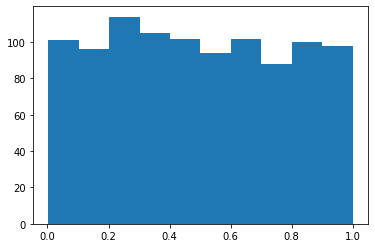

In [17]:
#plt.hist(r, 10)
plt.hist(D1.next(1000), 10)

5) Проверить точность моделирования с помощью теста «равномерность двумерного
распределения» с уровнем значимости $\epsilon=0.05$. Параметр $k$ выбирать самостоятельно.

6) Проверить точность моделирования БСВ с помощью любого другого известного Вам теста согласия. Тест необходимо реализовать самостоятельно.

7) Определить длину периода выходной последовательности для генератора МКМ двумя способами: теоретически и практически.